# Data Preprocessing

In [21]:
import numpy as np # коммент для задачи
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm

In [22]:
data = pd.read_csv("labeled.csv")

In [23]:
data.toxic.value_counts()

0.0    9586
1.0    4826
Name: toxic, dtype: int64

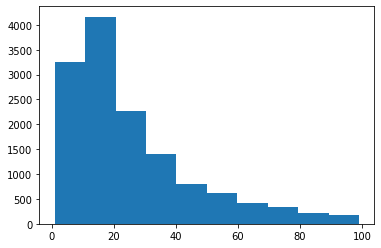

In [24]:
texts = list(data.comment)
lengths = [len(wordpunct_tokenize(text)) for text in texts]
lengths_less_than_n = [l for l in lengths if l < 100]
plt.hist(lengths_less_than_n)
plt.show()

In [25]:
np.mean(lengths), np.median(lengths)

(33.75707743547044, 20.0)

In [26]:
words = []
for text in texts:
    words.extend(wordpunct_tokenize(text))
len(words), len(set(words))

(486507, 76106)

In [27]:
len(words), len(set(words)) # 76к слов многовато для тф-идф 
                            # учитывая, что их там по 30 штук в среднем будут очень разреженные векторы

(486507, 76106)

In [28]:
words = []
for text in texts:
    words.extend(wordpunct_tokenize(text.lower()))
len(words), len(set(words))

(486507, 68638)

In [29]:
len(words), len(set(words))

(486507, 68638)

In [30]:
stop = stopwords.words('russian')
morph = MorphAnalyzer()

def lemmatize(words):
    new_words = []
    for word in words:
        new_words.append(morph.normal_forms(word)[0])
    return new_words

def drop_stopwords(words, stopwords):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

In [31]:
words = []
for i in tqdm(range(len(texts))):
    words.extend(lemmatize(wordpunct_tokenize(texts[i].lower())))
len(words), len(set(words))

100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [01:43<00:00, 139.56it/s]


(486507, 35315)

In [32]:
words = []
for i in tqdm(range(len(texts))):
    words.extend(lemmatize(drop_stopwords(wordpunct_tokenize(texts[i].lower()), stop)))
len(words), len(set(words))

100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [00:49<00:00, 291.75it/s]


(334170, 35243)

In [33]:
preprocessed_texts = []
for i in tqdm(range(len(texts))):
    preprocessed_texts.append(lemmatize(wordpunct_tokenize(texts[i].lower())))
len(words), len(set(words))

100%|███████████████████████████████████████████████████████████████████████████| 14412/14412 [01:43<00:00, 139.34it/s]


(334170, 35243)

In [34]:
final_texts = [' '.join(word for word in text) for text in preprocessed_texts]

In [35]:
len(final_texts)

14412

# TF-IDF + LogReg


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

In [82]:
X_train, X_val, y_train, y_val = train_test_split(final_texts, data.toxic, test_size=0.3, stratify=data.toxic)

In [83]:
pipe = Pipeline([ # по опыту берем логрег, так как деревяхи хреново работают с эмбеддингами и разреженными векторами
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression()),
])

In [84]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('clf', LogisticRegression())])

In [86]:
pred = pipe.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89      2876
         1.0       0.89      0.63      0.74      1448

    accuracy                           0.85      4324
   macro avg       0.86      0.80      0.82      4324
weighted avg       0.86      0.85      0.84      4324



# Нейронки 

In [14]:
# tf==2.8.0

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [47]:
vocab_size = 35000
max_len = 35
emb_size = 16

In [39]:
tok = Tokenizer(oov_token='<unk>',
                num_words = vocab_size)
tok.fit_on_texts(final_texts)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

In [44]:
def tokenize(text, tokenizer):
    seqs = tok.texts_to_sequences(text)
    seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='pre', maxlen = max_len)
    return seqs

In [45]:
X_train, X_val, y_train, y_val = train_test_split(final_texts, data.toxic, test_size=0.3, stratify=data.toxic)

In [46]:
X_train = tokenize(X_train, tok)
X_val = tokenize(X_val, tok)

In [62]:
X_train.shape

(10088, 35)

## CNN

In [69]:
model_cnn = keras.Sequential([
    layers.Embedding(vocab_size + 1, emb_size),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Conv1D(16, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),  
    layers.Dense(1, activation='sigmoid') 
])

In [70]:
model_cnn.compile(
              optimizer='nadam',
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])

In [71]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          560016    
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          784       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          784       
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)               

In [87]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=1, verbose=1, restore_best_weights=True)]

history_cnn = model_cnn.fit(
    x=X_train,
    y=np.array(y_train),
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
    )

Epoch 1/20
158/158 [==============================] - 1s 6ms/step - loss: 0.2189 - accuracy: 0.9254 - val_loss: 0.3475 - val_accuracy: 0.8682
Epoch 2/20
158/158 [==============================] - 1s 6ms/step - loss: 0.1433 - accuracy: 0.9536 - val_loss: 0.3777 - val_accuracy: 0.8626
Epoch 2: early stopping


In [88]:
pred = model_cnn.predict(X_val)

In [89]:
pred_int = [1 if prediction > 0.5 else 0 for prediction in pred]

In [90]:
print(classification_report(y_val, pred_int))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2876
         1.0       0.83      0.76      0.79      1448

    accuracy                           0.87      4324
   macro avg       0.86      0.84      0.85      4324
weighted avg       0.87      0.87      0.87      4324



## RNN

In [99]:
model_rnn = keras.Sequential([
    layers.Embedding(vocab_size + 1, emb_size),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

In [100]:
model_rnn.compile(
              optimizer='nadam',
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])

In [101]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=1, verbose=1, restore_best_weights=True)]

history_rnn = model_rnn.fit(
    x=X_train,
    y=np.array(y_train),
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
    )

Epoch 1/20
158/158 [==============================] - 5s 18ms/step - loss: 0.5562 - accuracy: 0.7136 - val_loss: 0.4512 - val_accuracy: 0.7683
Epoch 2/20
158/158 [==============================] - 2s 16ms/step - loss: 0.2928 - accuracy: 0.8875 - val_loss: 0.3235 - val_accuracy: 0.8670
Epoch 3/20
158/158 [==============================] - 2s 16ms/step - loss: 0.1652 - accuracy: 0.9430 - val_loss: 0.3310 - val_accuracy: 0.8747
Epoch 3: early stopping


In [102]:
pred = model_rnn.predict(X_val)

In [103]:
pred_int = [1 if prediction > 0.5 else 0 for prediction in pred]

In [104]:
print(classification_report(y_val, pred_int))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90      2876
         1.0       0.88      0.70      0.78      1448

    accuracy                           0.87      4324
   macro avg       0.87      0.83      0.84      4324
weighted avg       0.87      0.87      0.86      4324



Результат примерно одинаковый при классическом и нейросетевом подходе. Так как привык оценивать по макро ф1, лучший результат показал подход через свёрточные сети.